In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import os
import gc
import pickle

0it [00:00, ?it/s]

In [2]:
train_data = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')

In [3]:
train_data.shape

(40479, 2)

In [4]:
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
#Split the
splitted_tags = train_data['tags'].map(lambda x: x.split(' '))
label_list=[]
for i in splitted_tags:
    for j in i:
        if j not in label_list:
            label_list.append(j)
print('Number of Classes: ',len(label_list))

Number of Classes:  17


In [6]:
#The classes
label_list

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [7]:
#The distribution of the classes
counts = {}
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0
counts

{'haze': 2696,
 'primary': 37512,
 'agriculture': 12314,
 'clear': 28430,
 'water': 7410,
 'habitation': 3659,
 'road': 8070,
 'cultivation': 4546,
 'slash_burn': 208,
 'cloudy': 2088,
 'partly_cloudy': 7260,
 'conventional_mine': 99,
 'bare_ground': 861,
 'artisinal_mine': 338,
 'blooming': 331,
 'selective_logging': 339,
 'blow_down': 100}

In [8]:
def create_mapping(train_data):
    tags = set()
    for tag in tqdm(list(train_data['tags'].values)):
        split = tag.split(' ')
        tags.update(split)
    tags = list(tags)
    tags.sort()
    
    labels = dict()
    for idx, tag in enumerate(tags):
        labels[tag] = idx
    
    return labels

labels = create_mapping(train_data)
labels

  0%|          | 0/40479 [00:00<?, ?it/s]

{'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [9]:
labels = {l: i for i, l in enumerate(counts)}
labels

{'haze': 0,
 'primary': 1,
 'agriculture': 2,
 'clear': 3,
 'water': 4,
 'habitation': 5,
 'road': 6,
 'cultivation': 7,
 'slash_burn': 8,
 'cloudy': 9,
 'partly_cloudy': 10,
 'conventional_mine': 11,
 'bare_ground': 12,
 'artisinal_mine': 13,
 'blooming': 14,
 'selective_logging': 15,
 'blow_down': 16}

In [10]:
def encode_tags(file_name, labels):
    encoded = np.zeros(len(labels), dtype='uint8')
    
    tags = train_data.query(f"image_name == '{file_name.split('.')[0]}'")['tags'].values[0].split(' ')
    for tag in tags:
        encoded[labels[tag]] = 1
    
    return encoded

In [11]:
train_path = '../input/planets-dataset/planet/planet/train-jpg/'

In [12]:
def create_variables(labels):
    images, targets = list(), list()
    
    for file_name in tqdm(os.listdir(train_path)[:35000]):
        photo = load_img(train_path + file_name , target_size = (128, 128))
        photo = img_to_array(photo, dtype='uint8')
        
        encoded = encode_tags(file_name, labels)
        
        images.append(photo)
        targets.append(encoded)
    
    X = np.asarray(images, dtype='uint8')
    y = np.asarray(targets)
    
    
    return X, y

In [13]:
X, y = create_variables(labels)

  0%|          | 0/35000 [00:00<?, ?it/s]

In [14]:
image_name = X
tags = y

In [15]:
np.savez_compressed('planet_data.npz', image_name, tags)

In [16]:
del X, y
del image_name, tags
del train_data
gc.collect()

361

In [17]:
def load_dataset():
    data = np.load('./planet_data.npz')
    
    image_name, tags = data['arr_0'], data['arr_1']
    
    X_train, X_test, y_train, y_test = train_test_split(image_name, tags, test_size=0.3, random_state=1)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_dataset()

In [18]:
X_test.shape

(10500, 128, 128, 3)

In [19]:
y_test

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [20]:
train_yhat = np.asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])
test_yhat = np.asarray([np.ones(y_test.shape[1]) for _ in range(y_test.shape[0])])

train_xhat = np.asarray([np.ones(X_train.shape[1]) for _ in range(X_train.shape[0])])
test_xhat = np.asarray([np.ones(X_test.shape[1]) for _ in range(X_test.shape[0])])

In [21]:
print('Y Shape')
print(train_yhat.shape)
print(test_yhat.shape)
print('X Shape')
print(train_xhat.shape)
print(test_xhat.shape)

Y Shape
(24500, 17)
(10500, 17)
X Shape
(24500, 128)
(10500, 128)


In [22]:
y_train = train_yhat
y_test = test_yhat

In [23]:
new_dimension = np.prod(train_xhat.shape[1:])

In [24]:
new_dimension

128

In [25]:
x_train = train_xhat.reshape(train_xhat.shape[0], new_dimension)
x_test = test_xhat.reshape(test_xhat.shape[0], new_dimension)
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))

x_train: (24500, 128)
x_test: (10500, 128)


In [26]:
no_labels = np.prod(train_yhat.shape[1:])

In [27]:
no_labels

17

In [28]:
y_train.shape

(24500, 17)

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(new_dimension,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(no_labels, activation='softmax'))
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

2022-09-20 14:15:28.498301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 14:15:28.612664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 14:15:28.613666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 14:15:28.616227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
history = model.fit(x_train, y_train, epochs=20, batch_size=100)

2022-09-20 14:15:31.220796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
245/245 [==============================] - 2s 2ms/step - loss: 205042.7656 - accuracy: 0.0816
Epoch 2/20
245/245 [==============================] - 1s 2ms/step - loss: 6464934.0000 - accuracy: 0.1510
Epoch 3/20
245/245 [==============================] - 0s 2ms/step - loss: 28555442.0000 - accuracy: 0.1102
Epoch 4/20
245/245 [==============================] - 0s 2ms/step - loss: 39979388.0000 - accuracy: 0.0939
Epoch 5/20
245/245 [==============================] - 0s 2ms/step - loss: 42653676.0000 - accuracy: 0.0694
Epoch 6/20
245/245 [==============================] - 0s 2ms/step - loss: 50643148.0000 - accuracy: 0.0694
Epoch 7/20
245/245 [==============================] - 1s 2ms/step - loss: 36178704.0000 - accuracy: 0.0653
Epoch 8/20
245/245 [==============================] - 0s 2ms/step - loss: 43996488.0000 - accuracy: 0.0571
Epoch 9/20
245/245 [==============================] - 0s 2ms/step - loss: 66341896.0000 - accuracy: 0.0612
Epoch 10/20
245/245 [===================

In [31]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

329/329 [==============================] - 1s 2ms/step - loss: 604373568.0000 - accuracy: 0.0000e+00
Test loss: 604373568.0
Test accuracy: 0.0


Text(0.5, 1.0, 'Loss Curves - before regularisation')

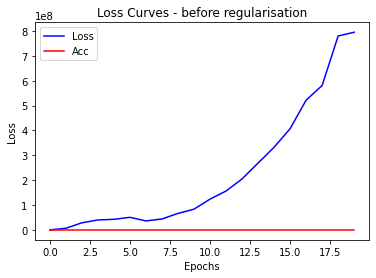

In [32]:
plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['accuracy'], 'red')
plt.legend(['Loss', 'Acc'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - before regularisation')

In [33]:
#Although the validation and training loss seem great, we can see that the validation #loss increases.
#We can introduce regularization
from tensorflow.keras.layers import Dropout
reg_model = Sequential()
reg_model.add(Dense(64, activation='relu', input_shape=(new_dimension,)))
reg_model.add(Dropout(0.2))
reg_model.add(Dense(64, activation='relu'))
reg_model.add(Dropout(0.2))
reg_model.add(Dense(32, activation='relu'))
reg_model.add(Dropout(0.2))
reg_model.add(Dense(32, activation='relu'))
reg_model.add(Dropout(0.2))
reg_model.add(Dense(32, activation='relu'))
reg_model.add(Dropout(0.2))
reg_model.add(Dense(no_labels, activation='softmax'))

reg_model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, 
 metrics=['accuracy'])

In [34]:
reg_history = reg_model.fit(x_train, y_train, epochs=20, batch_size=100)

Epoch 1/20
245/245 [==============================] - 1s 2ms/step - loss: 15118765.0000 - accuracy: 0.0393
Epoch 2/20
245/245 [==============================] - 1s 2ms/step - loss: 2966211840.0000 - accuracy: 0.1031
Epoch 3/20
245/245 [==============================] - 1s 2ms/step - loss: 45265670144.0000 - accuracy: 0.1080
Epoch 4/20
245/245 [==============================] - 1s 2ms/step - loss: 259548495872.0000 - accuracy: 0.1078
Epoch 5/20
245/245 [==============================] - 1s 2ms/step - loss: 907237851136.0000 - accuracy: 0.1063
Epoch 6/20
245/245 [==============================] - 1s 2ms/step - loss: 2362250100736.0000 - accuracy: 0.1090
Epoch 7/20
245/245 [==============================] - 1s 2ms/step - loss: 5122707423232.0000 - accuracy: 0.1109
Epoch 8/20
245/245 [==============================] - 1s 2ms/step - loss: 9719684005888.0000 - accuracy: 0.1092
Epoch 9/20
245/245 [==============================] - 1s 2ms/step - loss: 16792922619904.0000 - accuracy: 0.1098
Epo

In [35]:
#Regularized
test_loss, test_accuracy = reg_model.evaluate(x_test, y_test)
print('Test loss: {}'.format(test_loss))
test_accuracy = round(test_accuracy,1)
print('Test accuracy: {}'.format(test_accuracy))

329/329 [==============================] - 1s 2ms/step - loss: 319218444664832.0000 - accuracy: 0.0000e+00
Test loss: 319218444664832.0
Test accuracy: 0.0


Text(0.5, 1.0, 'Loss Curves - after regularisation')

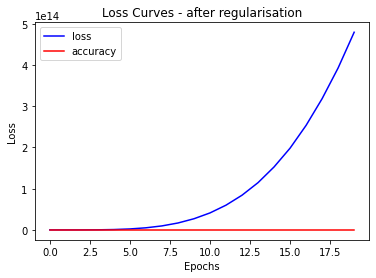

In [36]:
plt.figure()
plt.plot(reg_history.history['loss'], 'blue')
plt.plot(reg_history.history['accuracy'], 'red')
plt.legend(['loss', 'accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - after regularisation')